Support Classification
===

Project site: https://blablablab.si.umich.edu/projects/support/

Paper: https://www.aclweb.org/anthology/D18-1004


In [74]:
%matplotlib inline

from pathlib import Path
import os
import subprocess

import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

import sklearn
import sklearn.model_selection

In [21]:
# get data
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
data_dir = git_root_dir / 'support_classification' / 'data'
crowdflower_support_annotations_file = data_dir / 'crowdflower-support-annotations.csv'
training_data_file = data_dir / 'training-data.with-ids.tsv'
assert data_dir.exists() and crowdflower_support_annotations_file.exists() and training_data_file.exists()

In [5]:
df = pd.read_csv(crowdflower_support_annotations_file)
len(df)

/home/levon003/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,18,19,20,21,23,24,25,26,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


35828

In [6]:
df.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,post,post_id,post_user,reply,reply_id,reply_user,source,support_gold,support_gold_reason,type
0,1575933638,2/5/2018 06:11:28,True,3337204128,NaN,2/5/2018 06:07:30,False,clixsense,0.7727,43725761,...,"Thanks, I wasnt trying to be rude- it just ann...",cj207fn,NaN,It has to do with /r/atheism generally being a...,cj20cl7,NaN,reddit-AskReddit-2014,2\n3\n4,The reply doesn't address the author,long-long
1,1575933638,2/5/2018 06:33:46,True,3337235761,NaN,2/5/2018 06:31:40,False,clixsense,0.7500,40557293,...,"Thanks, I wasnt trying to be rude- it just ann...",cj207fn,NaN,It has to do with /r/atheism generally being a...,cj20cl7,NaN,reddit-AskReddit-2014,2\n3\n4,The reply doesn't address the author,long-long
2,1575933638,2/5/2018 06:49:11,True,3337257061,NaN,2/5/2018 06:44:46,False,clixsense,0.7273,42837258,...,"Thanks, I wasnt trying to be rude- it just ann...",cj207fn,NaN,It has to do with /r/atheism generally being a...,cj20cl7,NaN,reddit-AskReddit-2014,2\n3\n4,The reply doesn't address the author,long-long
3,1575933638,2/5/2018 07:25:10,True,3337311785,NaN,2/5/2018 07:22:42,False,neodev,0.7273,38644226,...,"Thanks, I wasnt trying to be rude- it just ann...",cj207fn,NaN,It has to do with /r/atheism generally being a...,cj20cl7,NaN,reddit-AskReddit-2014,2\n3\n4,The reply doesn't address the author,long-long
4,1575933638,2/5/2018 07:38:10,True,3337331241,NaN,2/5/2018 07:36:06,False,elite,0.7727,43402768,...,"Thanks, I wasnt trying to be rude- it just ann...",cj207fn,NaN,It has to do with /r/atheism generally being a...,cj20cl7,NaN,reddit-AskReddit-2014,2\n3\n4,The reply doesn't address the author,long-long


In [12]:
Counter([str(source).split("-")[0] for source in df.source]).most_common()

[('reddit', 12968),
 ('stackexchange', 10461),
 ('wiki', 7425),
 ('wikin', 4956),
 ('nan', 18)]

In [17]:
Counter([s for s in df.source if str(s).startswith('reddit')]).most_common()[:20]

[('reddit-AskReddit-2014', 646),
 ('reddit-AskReddit-2016', 499),
 ('reddit-pics-2017', 449),
 ('reddit-AskReddit-2013', 365),
 ('reddit-AskReddit-2017', 339),
 ('reddit-The_Donald-2017', 265),
 ('reddit-AskReddit-2015', 252),
 ('reddit-soccer-2016', 247),
 ('reddit-AdviceAnimals-2013', 243),
 ('reddit-worldnews-2015', 238),
 ('reddit-pics-2015', 230),
 ('reddit-politics-2015', 230),
 ('reddit-MMA-2016', 218),
 ('reddit-nfl-2015', 216),
 ('reddit-relationships-2015', 215),
 ('reddit-AdviceAnimals-2017', 215),
 ('reddit-gifs-2017', 214),
 ('reddit-xboxone-2016', 211),
 ('reddit-Showerthoughts-2015', 211),
 ('reddit-heroesofthestorm-2016', 196)]

In [19]:
len(df.groupby(by='reply_id'))

8979

### Training data file

https://github.com/davidjurgens/support/blob/master/data/training-data.with-ids.tsv

In [23]:
df = pd.read_csv(training_data_file, sep='\t')
len(df)

9030

In [24]:
df.head()

,agreement,offensiveness,politeness,support,post,reply,post_id,reply_id,source,platform
0,3.000000,1.000000,3.000000,3.000000,Well that didnt take long,What didnt?,cj4hzgi,cj4i1cc,reddit-worldnews-2014,reddit
1,3.000000,1.333333,3.333333,3.000000,Im always amused when Im flying home and there...,and what people think is Vegas is really Paradise,csvv5j9,csvy89s,reddit-pics-2015,reddit
2,2.333333,1.000000,3.000000,3.000000,"There was no absence of regulation back then, ...",Which back when? Im no ballerina but I dont th...,cswfklp,cswktwq,reddit-todayilearned-2015,reddit
3,4.333333,3.000000,2.000000,3.666667,**YEA** but he had calvin johnson so that mean...,EXACTLY! To all the Bears fans who say this...,c5c1eur,c5c1q9f,reddit-nfl-2012,reddit
4,3.000000,3.000000,2.333333,3.000000,Maybe it shouldnt be as easy as Arya made it seem,well when you have magical face changing power...,dkbgylh,dkbhbxt,reddit-asoiaf-2017,reddit


In [28]:
Counter(df.platform).most_common()

[('reddit', 3015), ('stackexchange', 3013), ('wiki', 2996), ('?', 6)]

In [25]:
Counter([str(source).split("-")[0] for source in df.source]).most_common()

[('reddit', 3015),
 ('stackexchange', 3013),
 ('wikin', 1652),
 ('wiki', 1344),
 ('?', 6)]

In [26]:
df['source_site'] = [str(source).split("-")[0] for source in df.source]

In [42]:
Counter(df.support).most_common()

[(3.0, 3787),
 (3.33333333333, 1823),
 (2.66666666667, 1448),
 (3.66666666667, 738),
 (2.33333333333, 577),
 (4.0, 303),
 (2.0, 175),
 (4.33333333333, 72),
 (1.6666666666699999, 68),
 (1.33333333333, 20),
 (4.66666666667, 11),
 (1.0, 4),
 (5.0, 2),
 (2.75, 1),
 (3.5, 1)]

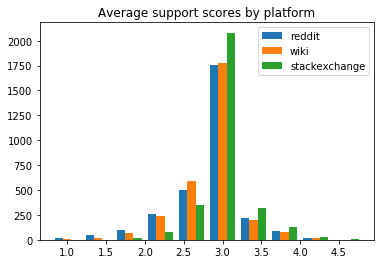

In [63]:
xs = []
labels = []
for platform in set(df.platform):
    if platform == '?':
        continue
    x = df[df.platform == platform].support
    xs.append(x)
    labels.append(platform)
plt.hist(xs, label=labels, align='left')
plt.legend()
plt.title("Average support scores by platform")
plt.show()

### Preprocessing with Spacy

In [43]:
import spacy

In [44]:
%%time
nlp = spacy.load('en_core_web_lg')

CPU times: user 8.15 s, sys: 935 ms, total: 9.08 s
Wall time: 17.4 s


In [45]:
tokens = []
embedding = []
for doc in tqdm(nlp.pipe(df.reply, batch_size=1000, n_threads=3)):
    tokens.append([token.text for token in doc])
    embedding.append(doc.vector)

9030it [00:49, 182.56it/s]


In [46]:
df['tokens'] = tokens
df['embedding'] = embedding
df.reset_index(inplace=True)

In [47]:
df.to_pickle(data_dir / 'tokenized.pkl')

In [48]:
df = pd.read_pickle(data_dir / 'tokenized.pkl')
len(df)

9030

In [49]:
df.tokens.head()

0                                   [What, did, nt, ?]
1    [and, what, people, think, is, Vegas, is, real...
2    [Which, back, when, ?, I, m, no, ballerina, bu...
3    [EXACTLY, !,    , To, all, the, Bears, fans, w...
4    [well, when, you, have, magical, face, changin...
Name: tokens, dtype: object

In [50]:
df.embedding.head()

0    [-0.06969675, 0.21982999, -0.07316275, -0.4447...
1    [-0.091369994, 0.31280944, -0.14858837, -0.336...
2    [0.09055326, 0.109529115, -0.13828273, -0.1614...
3    [-0.064493835, 0.20588325, -0.17942156, -0.104...
4    [-0.097393975, 0.14301756, -0.20241255, -0.029...
Name: embedding, dtype: object

### Classification with VW

In [228]:
def map_support_to_label(support):
    if support <= -0.67:
        return 1  # Unsupportive
    elif support >= 0.67:
        return 3  # Supportive
    else:
        return 2  # Neutral
    
def map_support_to_binary_label(support):
    # Assign positive if between 1 and 2
    if support > 0.67:
        return 1
    else:
        return 0

# write the dataframe to a file in the vowpal wabbit format
def to_vw_format(df, filename, discretize=True, binarize=False, use_embeddings=False, add_embeddings=False):
    with open(filename, 'w') as outfile:
        for i in range(len(df)):
            row = df.iloc[i]
            if binarize:
                label = map_support_to_binary_label(row.support - 3)
                label = "+1" if label == 1 else "-1"
            elif discretize:
                # we will use a multiclass model
                label = str(map_support_to_label(row.support - 3))
            else: # regression task
                label = str(row.support)
                raise NotImplemented("Support regression not implemented.")
            if use_embeddings:
                dim_features = []
                for i in range(len(row.embedding)):
                    feature = "d" + str(i) + ":" + str(row.embedding[i])
                    dim_features.append(feature)
                features = " ".join(dim_features)
            else:
                features = " ".join([token.replace(":", "COLON") for token in row.tokens])
                if add_embeddings:
                    dim_features = []
                    for i in range(len(row.embedding)):
                        feature = "d" + str(i) + ":" + str(row.embedding[i])
                        dim_features.append(feature)
                    features += " |E:0.01 " + " ".join(dim_features)
            line = f"{label} {row.reply_id}|R {features}\n"
            outfile.write(line)

In [71]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

In [112]:
# add discretized support label to the data
df['support_discretized'] = [map_support_to_label(s - 3) for s in df.support]
Counter(df.support_discretized).items()

dict_items([(2, 8375), (3, 388), (1, 267)])

In [113]:
# identify test data
test_percent = 0.2
train_df, test_df = sklearn.model_selection.train_test_split(df, test_size=test_percent)
len(train_df), len(test_df)

(7224, 1806)

In [191]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
sampling_strategy = 'auto'  # the default
neutral_class_count = Counter(train_df.support_discretized)[2]
sampling_strategy = {2: int(neutral_class_count), 
                     1: int(neutral_class_count * 0.9), 
                     3: int(neutral_class_count * 0.9)}

X_resampled, y_resampled = RandomOverSampler(sampling_strategy=sampling_strategy).fit_resample(
    train_df.index.values.reshape(-1, 1), 
    train_df.support_discretized)
most_resampled = Counter([val[0] for val in X_resampled]).most_common()[0][1]
mean_resampled = np.mean([val for val in Counter([val[0] for val in X_resampled]).values() if val > 1])
print(f"The most-resampled training data was replicated {most_resampled} times.")
print(f"Among rows that were replicated at least once, rows were replicated an average of {mean_resampled:.2f} times.")
train_df_resampled = train_df.loc[[val[0] for val in X_resampled]]
Counter(train_df_resampled.support_discretized).most_common()

The most-resampled training data was replicated 43 times.
Among rows that were replicated at least once, rows were replicated an average of 23.45 times.


[(2, 6709), (3, 6038), (1, 6038)]

In [192]:
%%time
train_filename = data_dir / 'vw_support_3class.train'
test_filename = data_dir / 'vw_support_3class.test'
to_vw_format(train_df_resampled, train_filename, use_embeddings=False)
to_vw_format(test_df, test_filename, use_embeddings=False)

CPU times: user 3.86 s, sys: 0 ns, total: 3.86 s
Wall time: 3.86 s


In [193]:
!wc -l {train_filename}

18785 /home/levon003/repos/sna-social-support/support_classification/data/vw_support_3class.train


In [194]:
!head -n 4 {train_filename}

2 61127|R no that was just me playing with java , but that program is what triggered this question . I wrote that program in hopes to try to prevent it from happening , the program was built with success , but the prevention failed . lol
3 5925688|R Thank you for the input . We can agree to disagree over whether ATC bears any responsibility at all for the tragedy . However , we do agree that the pilot error was at least the primary cause , and I am in full agreement with your edit . Thank you again .
2 d5womj3|R What if its not in the code because its hidden ? As in its something that s already in the code . Like it could be a pokeball in disguise sort - of like how ditto is ?
2 105487|R A couple of different points . First , the five pillars and six articles of faith we currently list here are Sunni classifications . RSs devote more space to Sunni than to Shia traditions , and so should we , but we should n't present these classifications as normative . The five pillars belong to the 

In [195]:
!vw -k -c -b 29 --passes 20 --oaa 3 -d {train_filename} -f {data_dir}/vw_support_3class.model --ngram 2

Generating 2-grams for all namespaces.
final_regressor = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_3class.model
Num weight bits = 29
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_3class.train.cache
Reading datafile = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_3class.train
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        2        1       90
1.000000 1.000000            2            2.0        3        2      106
0.500000 0.000000            4            4.0        2        2      436
0.250000 0.000000            8            8.0        2        2      222
0.125000 0.000000           16           16.0        2        2       96


In [196]:
!vw -t -i {data_dir}/vw_support_3class.model -d {test_filename} -p {test_filename}.pred

Generating 2-grams for all namespaces.
only testing
predictions = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_3class.test.pred
Num weight bits = 29
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_3class.test
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        2        2       14
0.500000 1.000000            2            2.0        3        2       72
0.250000 0.000000            4            4.0        2        2       74
0.125000 0.000000            8            8.0        2        2       72
0.125000 0.125000           16           16.0        2        2       12
0.156250 0.187500           32           32.0        2        3       56
0.140625 0.125000           64           64.

In [197]:
!head {test_filename}.pred

2 caxzw93
2 8982292
2 dkhlkmx
2 67292
2 ciw0jw3
2 14559299
2 261879
2 147113
2 caxh91p
2 231825


In [198]:
test_preds_filename = str(test_filename) + ".pred"
with open(test_preds_filename, 'r') as infile:
    lines = infile.readlines()
    preds_raw = [line.split()[0] for line in lines]
    preds = [int(raw_pred) for raw_pred in preds_raw]
len(preds), preds[:5]

(1806, [2, 2, 2, 2, 2])

In [199]:
Counter(preds).most_common()

[(2, 1655), (3, 121), (1, 30)]

In [200]:
y_true = [map_support_to_label(s - 3) for s in test_df.support]
Counter(y_true).most_common()

[(2, 1666), (3, 80), (1, 60)]

In [201]:
print(sklearn.metrics.classification_report(y_true, preds, target_names=['Unsupportive', 'Neutral', 'Supportive']))

              precision    recall  f1-score   support

Unsupportive       0.30      0.15      0.20        60
     Neutral       0.93      0.93      0.93      1666
  Supportive       0.15      0.23      0.18        80

   micro avg       0.87      0.87      0.87      1806
   macro avg       0.46      0.43      0.44      1806
weighted avg       0.88      0.87      0.87      1806



## Binary classification of supportive replies

In [230]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df['support_binary'] = [map_support_to_binary_label(s - 3) for s in df.support]
print("Overall support distribution")
print(Counter(df.support_binary).items())

# identify test data
test_percent = 0.2
train_df, test_df = sklearn.model_selection.train_test_split(df, test_size=test_percent)
print("Train/test split:")
print(len(train_df), len(test_df))

from imblearn.over_sampling import RandomOverSampler
negative_class_count = Counter(train_df.support_binary)[0]
sampling_strategy = {0: int(negative_class_count), 
                     1: int(negative_class_count * 0.2)}
X_resampled, y_resampled = RandomOverSampler(sampling_strategy=sampling_strategy).fit_resample(
    train_df.index.values.reshape(-1, 1), 
    train_df.support_binary)
train_df_resampled = train_df.loc[[val[0] for val in X_resampled]]
print("Train support distribution after resampling:")
print(Counter(train_df_resampled.support_binary).most_common())

train_filename = data_dir / 'vw_support_binary.train'
test_filename = data_dir / 'vw_support_binary.test'
to_vw_format(train_df_resampled, train_filename, binarize=True, discretize=False, add_embeddings=False)
to_vw_format(test_df, test_filename, binarize=True, discretize=False, add_embeddings=False)
print("Wrote out train and test files in VW format.")

!vw -k -c -b 30 --passes 20 --binary {train_filename} -f {data_dir}/vw_support_binary.model --ngram 2
print()

!vw --binary -t -i {data_dir}/vw_support_binary.model -d {test_filename} -p {test_filename}.pred
print()

test_preds_filename = str(test_filename) + ".pred"
with open(test_preds_filename, 'r') as infile:
    lines = infile.readlines()
    preds_raw = [line.split()[0] for line in lines]
    preds = [max(int(raw_pred), 0) for raw_pred in preds_raw]
print("Loaded predictions:", len(preds), preds[:5])

print("Prediction support distribution:", Counter(preds).most_common())

y_true = [map_support_to_binary_label(s - 3) for s in test_df.support]
print("Test support distribution:", Counter(y_true).most_common())

print(sklearn.metrics.classification_report(y_true, preds, target_names=['Unsupportive', 'Supportive']))

Overall support distribution
dict_items([(0, 8642), (1, 388)])
Train/test split:
7224 1806
Train support distribution after resampling:
[(0, 6905), (1, 1381)]
Wrote out train and test files in VW format.
Generating 2-grams for all namespaces.
final_regressor = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_binary.model
Num weight bits = 30
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_binary.train.cache
Reading datafile = /home/levon003/repos/sna-social-support/support_classification/data/vw_support_binary.train
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  -1.0000  -1.0000       22
0.000000 0.000000            2            2.0  -1.0000  -1.0000       22
0.000000 0.0000